# Heart Disease Prediction: Hyperparameter Tuning Modellinng

## RadomSearchCV For Hyperparameter Tuning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV


import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('./data/scaler.csv')
df.head()

,General_Health,Checkup,Exercise,Skin_Cancer,Other_Cancer,Depression,Diabetes,Arthritis,Age_Category,Height_(cm),Weight_(kg),BMI,Smoking_History,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption,Sex_Female,Sex_Male,Heart_Disease
0,-2.453624,-0.757981,-1.855999,-0.327999,-0.327302,-0.500733,-0.401235,1.433608,0.983082,-1.934174,-2.386101,-2.159624,1.210405,-0.621626,0.006665,0.059662,0.664357,0.963321,-0.963321,0
1,0.455490,0.468728,-1.855999,-0.327999,-0.327302,-0.500733,2.492304,-0.697541,0.983082,-0.526840,-0.303613,-0.051639,-0.826170,-0.621626,0.006665,-1.012228,-0.267626,0.963321,-0.963321,1
2,0.455490,0.468728,0.538794,-0.327999,-0.327302,-0.500733,2.492304,-0.697541,0.415464,-0.714485,0.227668,0.742497,-0.826170,-0.133847,-0.716871,-0.811248,1.130348,0.963321,-0.963321,0
3,-2.453624,0.468728,0.538794,-0.327999,-0.327302,-0.500733,2.492304,-0.697541,1.266891,0.880494,0.461450,0.015817,-0.826170,-0.621626,0.006665,0.997565,0.198366,-1.038076,1.038076,1
4,-0.514215,0.468728,-1.855999,-0.327999,-0.327302,-0.500733,-0.401235,-0.697541,1.550700,1.912539,0.227668,-0.652606,1.210405,-0.621626,-0.877656,-0.744255,-0.733617,-1.038076,1.038076,0


## SMOTE For Training Set

In [2]:
# Original X, y
X = df.drop(['Heart_Disease'], axis=1)
y = df['Heart_Disease']


In [3]:
# Splitting the training, testing set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [4]:
# Use SMOTE for Resampling
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy='minority', random_state = 5)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

### Logistic Regression

In [5]:
# Model tuning
from sklearn.linear_model import LogisticRegression

log_params = {
    'C': [0.00001, 0.001, 0.01, 1.0], 
    'penalty': ['l1', 'l2', 'elasticnet'],
    'solver': [ 'liblinear', 'lbfgs'],
    'max_iter' : [100, 500]
}

# Random Search for Logistic Regression
rh_log_reg = RandomizedSearchCV(estimator=LogisticRegression(random_state=1), param_distributions=log_params,n_iter=10,scoring='roc_auc',cv=5)
rh_log_reg.fit(X_resampled, y_resampled)

# Get best hyperparameters and models
best_params_logreg = rh_log_reg.best_params_
best_model_logreg = rh_log_reg.best_estimator_

print("best_params_logreg:", best_params_logreg)
print("best_model_logreg:", best_model_logreg)


best_params_logreg: {'solver': 'lbfgs', 'penalty': 'l2', 'max_iter': 500, 'C': 0.01}
best_model_logreg: LogisticRegression(C=0.01, max_iter=500, random_state=1)


In [6]:
# Final Logistic Regression Model
log_reg_tuned = LogisticRegression(**best_params_logreg)
log_reg_tuned = log_reg_tuned.fit(X_resampled,y_resampled)

In [7]:
acc_train = log_reg_tuned.score(X_resampled,y_resampled)
print(f'acc train: {acc_train}')

acc_test = log_reg_tuned.score(X_test,y_test)
print(f'acc test: {acc_test}')

acc train: 0.770653940512423
acc test: 0.7393733300947292


In [8]:
# Get a classification report with multiple statistics

y_pred = log_reg_tuned.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.73      0.84     56761
           1       0.21      0.80      0.33      4994

    accuracy                           0.74     61755
   macro avg       0.59      0.77      0.58     61755
weighted avg       0.91      0.74      0.80     61755



Interpretation of Results:

Precision: Out of all the instances that the model predicted as positive, how many are actually positive. A precision score of 0.98 for class 0  means that 98% of the instances that the model predicted as class 0 are actually class 0. Similarly, a precision score of 0.21 for class 1  means that only 21% of the instances that the model predicted as class 1 are actually class 1.

Recall: Out of all the actual positive instances, how many the model correctly identified. A recall score of 0.73 for class 0  means that the model correctly identified 73% of all actual class 0 instances. Similarly, a recall score of 0.80 for class 1  means that the model correctly identified 80% of all actual class 1 instances.

F1-score: The harmonic mean of precision and recall. An F1 score reaches its best value at 1 (perfect precision and recall) and worst at 0. It's a good way to summarize the evaluation of the model with a single number. 

Support: The number of actual instances for each class in the test data. 

Accuracy: The ratio of correct predictions to total predictions. An accuracy of 0.74 means that the model correctly predicted the class for 74% of all instances. 

Macro avg: The average precision, recall, or F1-score without considering the proportion for each class. 

Weighted avg: The average precision, recall, or F1-score considering the proportion for each class. 

In [9]:
# Calculate roc_auc_score
# Which is the area under the ROC curve, which is the curve having False Positive Rate on the x-axis 
#   and True Positive Rate on the y-axis at all classification thresholds

roc_auc_score(y_test, log_reg_tuned.predict_proba(X_test)[:,1])

0.8369709407706506

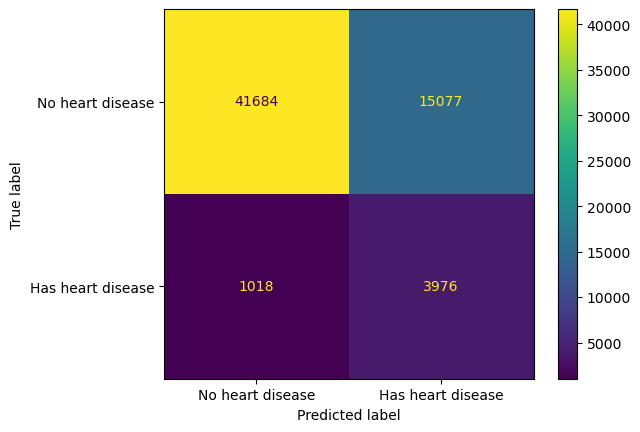

In [10]:
# Creating a confusion matrix; 
# True Neg == Top left, True Pos == Bottom Right
# False Neg == Bottom Left, False Pos == Top Right

# Building a confusion matrix to display the performance of the model.
cm = confusion_matrix(y_test, y_pred, labels = log_reg_tuned.classes_)
cm_disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["No heart disease", "Has heart disease"])
cm_disp.plot()


Interpretation of Results:

True negatives (TN): 41684 - The model correctly predicted no heart disease for these instances.

False positives (FP): 15077 - The model incorrectly predicted has heart diesease for these instances, which are actually no heart disease

False negatives (FN): 1018 - The model incorrectly predicted no heart disease for these instances, which are actually has heart disease.

True positives (TP): 3976 - The model correctly predicted heart disease for these instances.

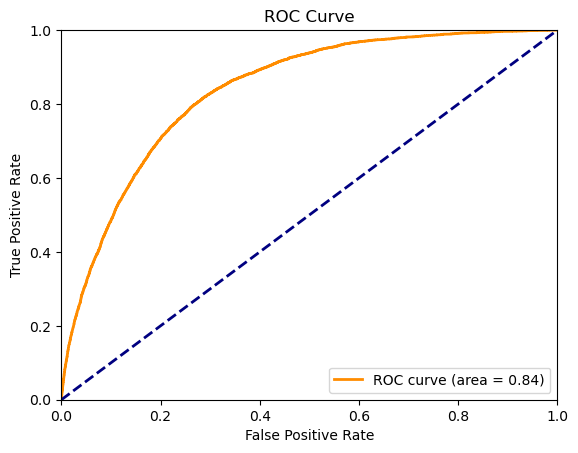

In [11]:
# Compute ROC curve and ROC area
y_pred_proba = log_reg_tuned.predict_proba(X_test)[:, 1]
fpr_optimized, tpr_optimized, _ = roc_curve(y_test, y_pred_proba)
roc_auc_optimized = auc(fpr_optimized, tpr_optimized)

# Plot ROC curve
# ROC curve under area is roc_auc_score(AUC)
plt.figure()
plt.plot(fpr_optimized, tpr_optimized, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_optimized)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

Interpretation of Results:

AUC (Area Under The ROC Curve): 0.84 - This means that the model has a 84% chance of correctly classifying a randomly chosen positive instance as more likely to be positive than a randomly chosen negative one.

An AUC of 1.0 represents a perfect model that makes no mistakes, while an AUC of 0.5 represents a model that performs no better than random chance. Therefore, an AUC of 0.84 is a reasonably good value.

## K-Nearest Neighbors

In [12]:
# Model tuning
from sklearn.neighbors import KNeighborsClassifier

knn_params = {
    'n_neighbors': [2, 5, 8], 
    'weights' : ['uniform', 'distance']
}

# Grid Search for Logistic Regression
rh_knn = RandomizedSearchCV(estimator=KNeighborsClassifier(), param_distributions=knn_params,n_iter=10,scoring='roc_auc',cv=5, verbose=3)
rh_knn.fit(X_resampled, y_resampled)

# Get best hyperparameters and models
best_params_knn = rh_knn.best_params_
best_model_knn = rh_knn.best_estimator_

print("best_params_knn:", best_params_knn)
print("best_model_knn:", best_model_knn)


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ....n_neighbors=2, weights=uniform;, score=0.941 total time= 2.3min
[CV 2/5] END ....n_neighbors=2, weights=uniform;, score=0.938 total time= 2.3min
[CV 3/5] END ....n_neighbors=2, weights=uniform;, score=0.939 total time= 2.2min
[CV 4/5] END ....n_neighbors=2, weights=uniform;, score=0.939 total time= 1.9min
[CV 5/5] END ....n_neighbors=2, weights=uniform;, score=0.940 total time= 2.2min
[CV 1/5] END ...n_neighbors=2, weights=distance;, score=0.941 total time= 2.3min
[CV 2/5] END ...n_neighbors=2, weights=distance;, score=0.939 total time= 2.3min
[CV 3/5] END ...n_neighbors=2, weights=distance;, score=0.940 total time= 2.4min
[CV 4/5] END ...n_neighbors=2, weights=distance;, score=0.939 total time= 2.4min
[CV 5/5] END ...n_neighbors=2, weights=distance;, score=0.940 total time= 2.3min
[CV 1/5] END ....n_neighbors=5, weights=uniform;, score=0.954 total time= 2.4min
[CV 2/5] END ....n_neighbors=5, weights=uniform;,

In [13]:
# Final KNeighborsClassifier Model
knn_tuned = KNeighborsClassifier(**best_params_knn)
knn_tuned = knn_tuned.fit(X_resampled,y_resampled)

In [14]:
# Get a classification report with multiple statistics

y_pred = knn_tuned.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.77      0.85     56761
           1       0.18      0.58      0.28      4994

    accuracy                           0.75     61755
   macro avg       0.57      0.67      0.56     61755
weighted avg       0.89      0.75      0.80     61755



In [17]:
# Calculate Accuracy
acc_train = knn_tuned.score(X_resampled,y_resampled)
print(f'acc train: {acc_train}')

acc_test = knn_tuned.score(X_test,y_test)
print(f'acc test: {acc_test}')

acc train: 0.9999889886759543
acc test: 0.7526516071573152


In [18]:
# Calculate roc_auc_score

roc_auc_score(y_test, knn_tuned.predict_proba(X_test)[:, 1])

0.7418917782115834

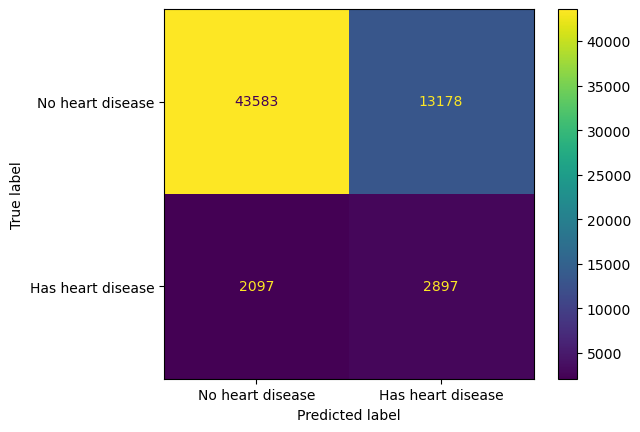

In [19]:
# Creating a confusion matrix; 
# True Neg == Top left, True Pos == Bottom Right
# False Neg == Bottom Left, False Pos == Top Right

# Building a confusion matrix to display the performance of the model.
cm = confusion_matrix(y_test, y_pred, labels = knn_tuned.classes_)
cm_disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["No heart disease", "Has heart disease"])
cm_disp.plot()

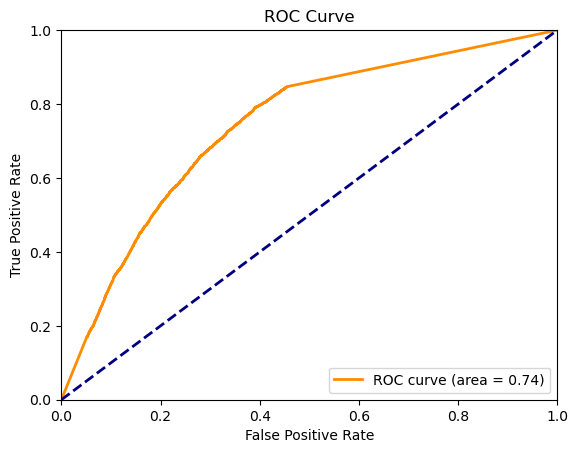

In [46]:
# Compute ROC curve and ROC area
y_pred_proba = knn_tuned.predict_proba(X_test)[:, 1]
fpr_optimized, tpr_optimized, _ = roc_curve(y_test, y_pred_proba)
roc_auc_optimized = auc(fpr_optimized, tpr_optimized)

# Plot ROC curve
# ROC curve under area is roc_auc_score(AUC)
plt.figure()
plt.plot(fpr_optimized, tpr_optimized, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_optimized)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


## Decision Tree

In [29]:
# Model tuning
from sklearn.tree import DecisionTreeClassifier

dt_params = {
    'max_depth': [5, 10, None],
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3]  
}

# Radom Search for Decision Tree
rh_dt = RandomizedSearchCV(estimator=DecisionTreeClassifier(random_state=30), param_distributions=dt_params,n_iter=10,scoring='roc_auc',cv=5, verbose=3)
rh_dt.fit(X_resampled, y_resampled)

# Get best hyperparameters and models
best_params_dt = rh_dt.best_params_
best_model_dt = rh_dt.best_estimator_

print("best_params_dt:", best_params_dt)
print("best_model_dt:", best_model_dt)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END criterion=gini, max_depth=None, min_samples_leaf=2, min_samples_split=5;, score=0.799 total time=   8.0s
[CV 2/5] END criterion=gini, max_depth=None, min_samples_leaf=2, min_samples_split=5;, score=0.966 total time=   6.6s
[CV 3/5] END criterion=gini, max_depth=None, min_samples_leaf=2, min_samples_split=5;, score=0.965 total time=   8.8s
[CV 4/5] END criterion=gini, max_depth=None, min_samples_leaf=2, min_samples_split=5;, score=0.964 total time=   7.3s
[CV 5/5] END criterion=gini, max_depth=None, min_samples_leaf=2, min_samples_split=5;, score=0.965 total time=   9.6s
[CV 1/5] END criterion=entropy, max_depth=5, min_samples_leaf=2, min_samples_split=5;, score=0.851 total time=   4.5s
[CV 2/5] END criterion=entropy, max_depth=5, min_samples_leaf=2, min_samples_split=5;, score=0.894 total time=   5.2s
[CV 3/5] END criterion=entropy, max_depth=5, min_samples_leaf=2, min_samples_split=5;, score=0.895 total time=   

In [30]:
# Final Decision Tree Model
dt_tuned = DecisionTreeClassifier(**best_params_dt)
dt_tuned = dt_tuned.fit(X_resampled,y_resampled)

In [31]:
# Get a classification report with multiple statistics

y_pred = dt_tuned.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.90      0.92     56761
           1       0.27      0.42      0.33      4994

    accuracy                           0.86     61755
   macro avg       0.61      0.66      0.63     61755
weighted avg       0.89      0.86      0.87     61755



In [32]:
# Calcualte Accuracy
acc_train = dt_tuned.score(X_resampled,y_resampled)
print(f'acc train: {acc_train}')

acc_test = dt_tuned.score(X_test,y_test)
print(f'acc test: {acc_test}')

acc train: 0.886940129228899
acc test: 0.8615010930289045


In [33]:
# Calculate roc_auc_score

roc_auc_score(y_test, dt_tuned.predict_proba(X_test)[:, 1])

0.8137600853304934

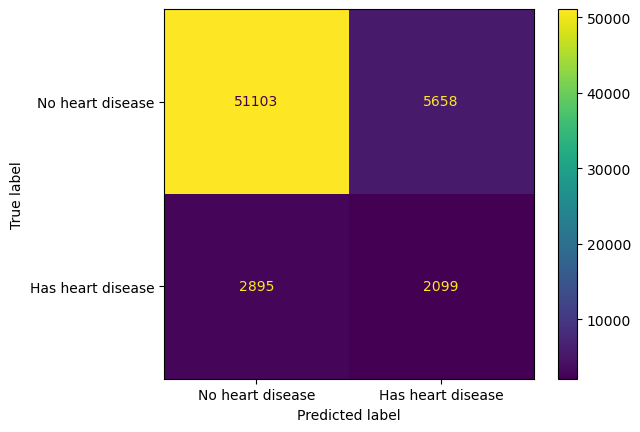

In [34]:
# Creating a confusion matrix; 
# True Neg == Top left, True Pos == Bottom Right
# False Neg == Bottom Left, False Pos == Top Right

# Building a confusion matrix to display the performance of the model.
cm = confusion_matrix(y_test, y_pred, labels = dt_tuned.classes_)
cm_disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["No heart disease", "Has heart disease"])
cm_disp.plot()



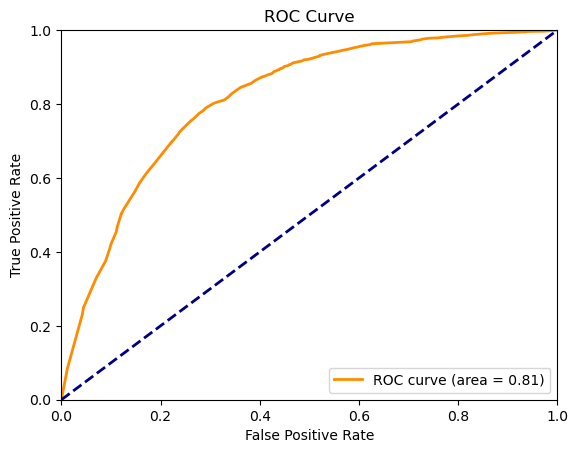

In [35]:
# Compute ROC curve and ROC area
y_pred_proba = dt_tuned.predict_proba(X_test)[:, 1]
fpr_optimized, tpr_optimized, _ = roc_curve(y_test, y_pred_proba)
roc_auc_optimized = auc(fpr_optimized, tpr_optimized)

# Plot ROC curve
# ROC curve under area is roc_auc_score(AUC)
plt.figure()
plt.plot(fpr_optimized, tpr_optimized, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_optimized)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

## Random Forest

In [22]:
# Model tuning
from sklearn.ensemble import RandomForestClassifier

rf_params = {
    'n_estimators': [10, 100], 
    'max_depth': [10, None],
    'criterion': ['gini', 'entropy'],   
    'min_samples_split': [2, 5, 10],  
    'min_samples_leaf': [1, 2, 3]     
}


# Random Search for Random Forest
rh_rforest = RandomizedSearchCV(estimator=RandomForestClassifier(random_state=30), param_distributions=rf_params,n_iter=10,scoring='roc_auc',cv=5, verbose=3)
rh_rforest.fit(X_resampled, y_resampled)

# Get best hyperparameters and models
best_params_rf = rh_rforest.best_params_
best_model_rf = rh_rforest.best_estimator_

print("best_params_rforest:", best_params_rf)
print("best_model_rforest:", best_model_rf)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END criterion=entropy, max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=10;, score=0.942 total time=  23.4s
[CV 2/5] END criterion=entropy, max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=10;, score=0.997 total time=  18.2s
[CV 3/5] END criterion=entropy, max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=10;, score=0.997 total time=  22.3s
[CV 4/5] END criterion=entropy, max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=10;, score=0.997 total time=  21.1s
[CV 5/5] END criterion=entropy, max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=10;, score=0.997 total time=  20.6s
[CV 1/5] END criterion=entropy, max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=100;, score=0.956 total time= 3.7min
[CV 2/5] END criterion=entropy, max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=1

In [23]:
# Final Random Forest Model
rforest_tuned = RandomForestClassifier(**best_params_rf)
rforest_tuned = rforest_tuned.fit(X_resampled,y_resampled)

In [24]:
# Get a classification report with multiple statistics

y_pred = rforest_tuned.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.98      0.95     56761
           1       0.39      0.17      0.24      4994

    accuracy                           0.91     61755
   macro avg       0.66      0.57      0.60     61755
weighted avg       0.89      0.91      0.89     61755



In [25]:
# Calculate Accuracy
acc_train = rforest_tuned.score(X_resampled,y_resampled)
print(f'acc train: {acc_train}')

acc_test = rforest_tuned.score(X_test,y_test)
print(f'acc test: {acc_test}')

acc train: 0.9853571412840966
acc test: 0.9108574204517853


In [26]:
# Calculate roc_auc_score

roc_auc_score(y_test, rforest_tuned.predict_proba(X_test)[:, 1])

0.8243553051879517

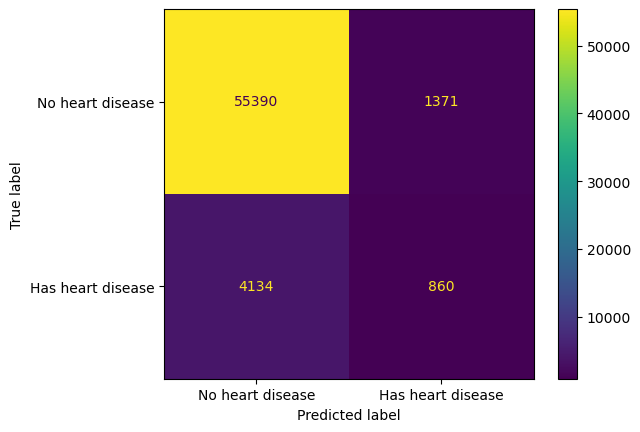

In [27]:
# Creating a confusion matrix; 
# True Neg == Top left, True Pos == Bottom Right
# False Neg == Bottom Left, False Pos == Top Right

# Building a confusion matrix to display the performance of the model.
cm = confusion_matrix(y_test, y_pred, labels = rforest_tuned.classes_)
cm_disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["No heart disease", "Has heart disease"])
cm_disp.plot()



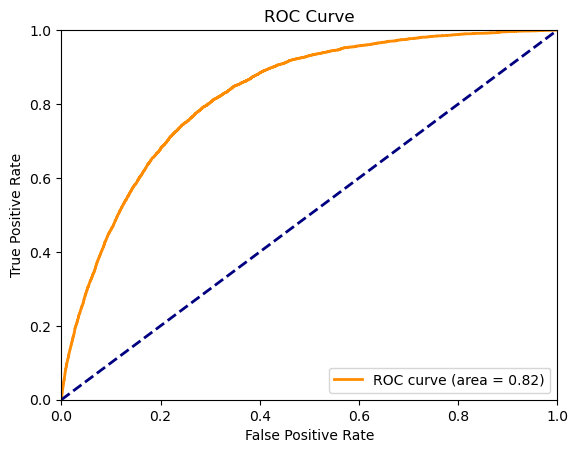

In [28]:
# Compute ROC curve and ROC area
y_pred_proba = rforest_tuned.predict_proba(X_test)[:, 1]
fpr_optimized, tpr_optimized, _ = roc_curve(y_test, y_pred_proba)
roc_auc_optimized = auc(fpr_optimized, tpr_optimized)

# Plot ROC curve
# ROC curve under area is roc_auc_score(AUC)
plt.figure()
plt.plot(fpr_optimized, tpr_optimized, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_optimized)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

## XGBoost

In [36]:
# XGBoost Tuning
from xgboost import XGBClassifier

xgb_params = {
    'learning_rate' : [0.05,0.20,0.30],
    'max_depth' : [3, 6, 8],  
    'min_child_weight' : [ 1, 3, 5],
    'gamma' : [ 0.0, 0.2 , 0.3],
    'colsample_bytree' : [ 0.3, 0.5 , 1.0]
}

# Create RandomizedSearchCV object
rh_xgb = RandomizedSearchCV(estimator=XGBClassifier(random_state=30), param_distributions=xgb_params,n_iter=10,scoring='roc_auc',cv=5)
rh_xgb.fit(X_resampled, y_resampled)

# Get best hyperparameters and model
best_params_xgb = rh_xgb.best_params_
best_model_xgb = rh_xgb.best_estimator_

print("Best Hyperparameters for XGBoost:", best_params_xgb)
print("Best XGBoost Model:", best_model_xgb)

Best Hyperparameters for XGBoost: {'min_child_weight': 5, 'max_depth': 6, 'learning_rate': 0.2, 'gamma': 0.0, 'colsample_bytree': 1.0}
Best XGBoost Model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=30, ...)


In [37]:
# Final Random Forest Model
xgb_tuned = XGBClassifier(**best_params_xgb)
xgb_tuned = xgb_tuned.fit(X_resampled,y_resampled)

In [38]:
# Get a classification report with multiple statistics

y_pred = xgb_tuned.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.99      0.96     56761
           1       0.49      0.06      0.10      4994

    accuracy                           0.92     61755
   macro avg       0.71      0.53      0.53     61755
weighted avg       0.89      0.92      0.89     61755



In [39]:
# Calculate Accuracy
acc_train = xgb_tuned.score(X_resampled,y_resampled)
print(f'acc train: {acc_train}')

acc_test = xgb_tuned.score(X_test,y_test)
print(f'acc test: {acc_test}')

acc train: 0.9558754222842771
acc test: 0.9189215448141851


In [40]:
# Calculate roc_acu_score

roc_auc_score(y_test, xgb_tuned.predict_proba(X_test)[:, 1])

0.8348948566859713

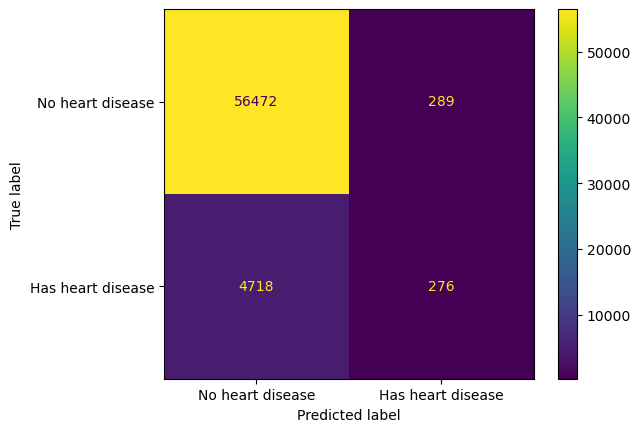

In [41]:
# Creating a confusion matrix; 
# True Neg == Top left, True Pos == Bottom Right
# False Neg == Bottom Left, False Pos == Top Right

# Building a confusion matrix to display the performance of the model.
cm = confusion_matrix(y_test, y_pred, labels = xgb_tuned.classes_)
cm_disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["No heart disease", "Has heart disease"])
cm_disp.plot()

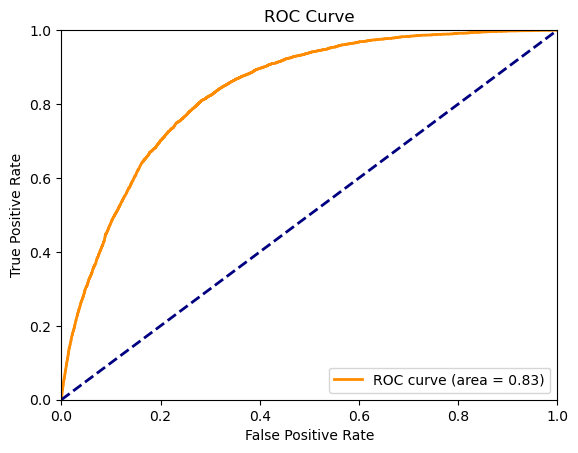

In [42]:
# Compute ROC curve and ROC area
y_pred_proba = xgb_tuned.predict_proba(X_test)[:, 1]
fpr_optimized, tpr_optimized, _ = roc_curve(y_test, y_pred_proba)
roc_auc_optimized = auc(fpr_optimized, tpr_optimized)

# Plot ROC curve
# ROC curve under area is roc_auc_score(AUC)
plt.figure()
plt.plot(fpr_optimized, tpr_optimized, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_optimized)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

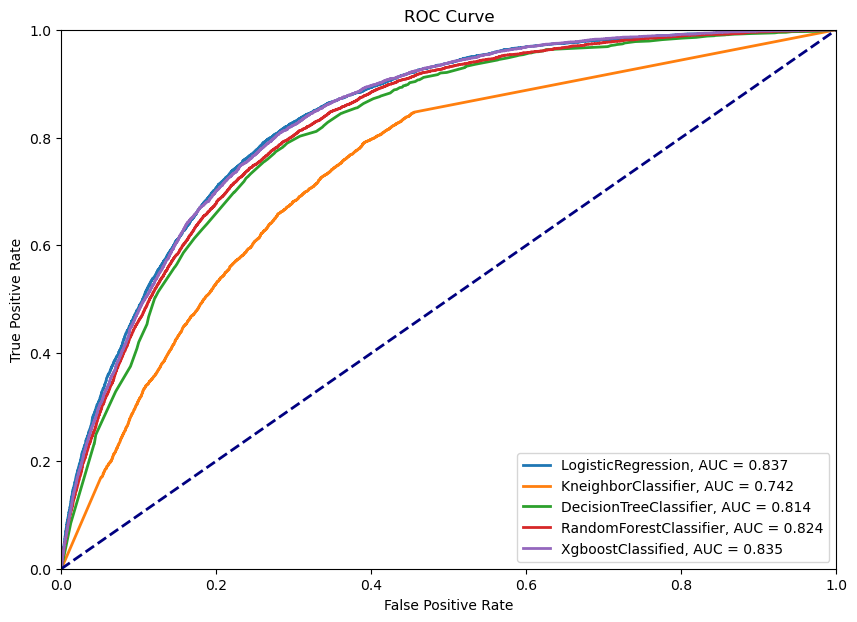

In [44]:
plt.figure(figsize=(10,7))

# Compute ROC curve and ROC area
y_pred_proba = log_reg_tuned.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, label='LogisticRegression, AUC = %0.3f' % roc_auc)

# Compute ROC curve and ROC area
y_pred_proba = knn_tuned.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, label='KneighborClassifier, AUC = %0.3f' % roc_auc)

# Compute ROC curve and ROC area
y_pred_proba = dt_tuned.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, label='DecisionTreeClassifier, AUC = %0.3f' % roc_auc)

# Compute ROC curve and ROC area
y_pred_proba = rforest_tuned.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, label='RandomForestClassifier, AUC = %0.3f' % roc_auc)

# Compute ROC curve and ROC area
y_pred_proba = xgb_tuned.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, label='XgboostClassified, AUC = %0.3f' % roc_auc)


plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()
